In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/1st_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.75

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomRotation(degrees=(-180, 180)),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
        v2.RandomResizedCrop(IMG_SIZE),
        #v2.RandomZoomOut(fill=1)  
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.5, 1.2], saturation=[0.6, 1.2], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=2),
        
    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




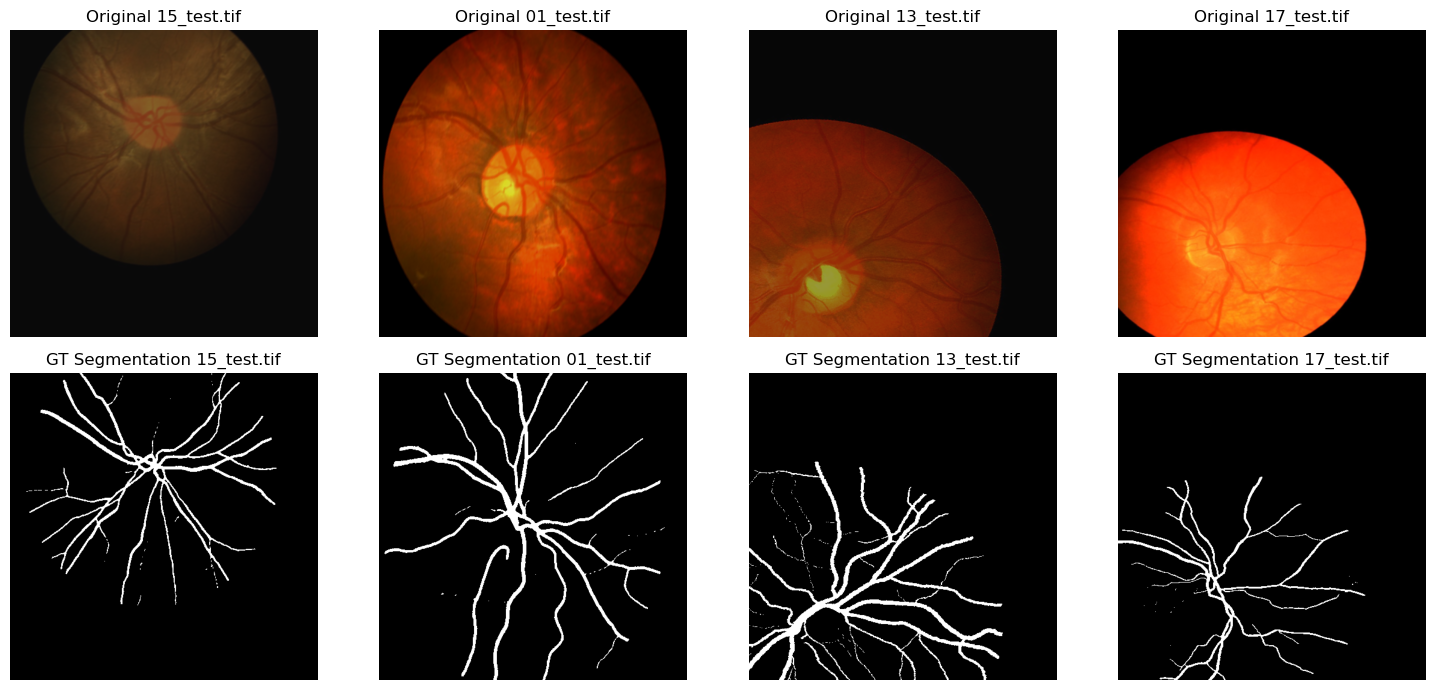

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
from unet import UNet
model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

from torchsummary import summary
summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
             Block-7         [-1, 64, 512, 512]               0
        InputBlock-8         [-1, 64, 512, 512]               0
         MaxPool2d-9         [-1, 64, 256, 256]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 200

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss()



# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            #print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            #print(f"Ground truth values: {ground_truth.unique()}")

            loss = loss_fn(pred, ground_truth)
            
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state

    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 1/200 | Training loss: 0.36917 | Validation loss: 0.38915 | Training accuracy: 72.46% | Validation accuracy: 94.90%




100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 2/200 | Training loss: 0.33951 | Validation loss: 0.37402 | Training accuracy: 86.04% | Validation accuracy: 93.31%




100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 3/200 | Training loss: 0.31506 | Validation loss: 0.38169 | Training accuracy: 93.72% | Validation accuracy: 73.50%




100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 4/200 | Training loss: 0.30325 | Validation loss: 0.33931 | Training accuracy: 94.85% | Validation accuracy: 94.91%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 5/200 | Training loss: 0.29753 | Validation loss: 0.34115 | Training accuracy: 94.72% | Validation accuracy: 95.66%




100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch: 6/200 | Training loss: 0.28899 | Validation loss: 0.32675 | Training accuracy: 93.72% | Validation accuracy: 93.79%




100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch: 7/200 | Training loss: 0.28104 | Validation loss: 0.31081 | Training accuracy: 94.85% | Validation accuracy: 93.96%




100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch: 8/200 | Training loss: 0.28104 | Validation loss: 0.30841 | Training accuracy: 89.64% | Validation accuracy: 94.00%




100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch: 9/200 | Training loss: 0.27408 | Validation loss: 0.29549 | Training accuracy: 94.67% | Validation accuracy: 95.19%




100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch: 10/200 | Training loss: 0.25617 | Validation loss: 0.27184 | Training accuracy: 95.54% | Validation accuracy: 94.90%




100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch: 11/200 | Training loss: 0.24085 | Validation loss: 0.28183 | Training accuracy: 94.38% | Validation accuracy: 95.26%




100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch: 12/200 | Training loss: 0.23388 | Validation loss: 0.27071 | Training accuracy: 94.93% | Validation accuracy: 95.88%




100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch: 13/200 | Training loss: 0.22431 | Validation loss: 0.25024 | Training accuracy: 94.63% | Validation accuracy: 97.23%




100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch: 14/200 | Training loss: 0.21750 | Validation loss: 0.23888 | Training accuracy: 94.32% | Validation accuracy: 94.40%




100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch: 15/200 | Training loss: 0.22503 | Validation loss: 0.24121 | Training accuracy: 94.39% | Validation accuracy: 93.90%




100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch: 16/200 | Training loss: 0.22078 | Validation loss: 0.24164 | Training accuracy: 97.03% | Validation accuracy: 93.61%




100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 17/200 | Training loss: 0.20128 | Validation loss: 0.21683 | Training accuracy: 96.50% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 18/200 | Training loss: 0.19547 | Validation loss: 0.21478 | Training accuracy: 96.32% | Validation accuracy: 96.07%




100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch: 19/200 | Training loss: 0.18731 | Validation loss: 0.20331 | Training accuracy: 96.03% | Validation accuracy: 94.13%




100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 20/200 | Training loss: 0.17383 | Validation loss: 0.22078 | Training accuracy: 96.13% | Validation accuracy: 96.26%




100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch: 21/200 | Training loss: 0.17330 | Validation loss: 0.19393 | Training accuracy: 96.51% | Validation accuracy: 95.90%




100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch: 22/200 | Training loss: 0.17937 | Validation loss: 0.20004 | Training accuracy: 95.68% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 23/200 | Training loss: 0.16627 | Validation loss: 0.19642 | Training accuracy: 96.10% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch: 24/200 | Training loss: 0.15968 | Validation loss: 0.16409 | Training accuracy: 96.44% | Validation accuracy: 96.91%




100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch: 25/200 | Training loss: 0.15722 | Validation loss: 0.16616 | Training accuracy: 96.02% | Validation accuracy: 97.47%




100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 26/200 | Training loss: 0.14588 | Validation loss: 0.17540 | Training accuracy: 96.38% | Validation accuracy: 96.98%




100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 27/200 | Training loss: 0.15138 | Validation loss: 0.18615 | Training accuracy: 96.73% | Validation accuracy: 95.72%




100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch: 28/200 | Training loss: 0.14134 | Validation loss: 0.14046 | Training accuracy: 96.30% | Validation accuracy: 96.97%




100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 29/200 | Training loss: 0.14389 | Validation loss: 0.13997 | Training accuracy: 96.19% | Validation accuracy: 97.40%




100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 30/200 | Training loss: 0.13682 | Validation loss: 0.15010 | Training accuracy: 96.65% | Validation accuracy: 97.08%




100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch: 31/200 | Training loss: 0.13537 | Validation loss: 0.13134 | Training accuracy: 96.86% | Validation accuracy: 96.88%




100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch: 32/200 | Training loss: 0.14445 | Validation loss: 0.13907 | Training accuracy: 97.05% | Validation accuracy: 95.08%




100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 33/200 | Training loss: 0.13143 | Validation loss: 0.12524 | Training accuracy: 96.73% | Validation accuracy: 96.68%




100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 34/200 | Training loss: 0.12376 | Validation loss: 0.15937 | Training accuracy: 97.32% | Validation accuracy: 96.10%




100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch: 35/200 | Training loss: 0.14147 | Validation loss: 0.13304 | Training accuracy: 95.57% | Validation accuracy: 97.30%




100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 36/200 | Training loss: 0.14341 | Validation loss: 0.16143 | Training accuracy: 96.53% | Validation accuracy: 95.66%




100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch: 37/200 | Training loss: 0.14845 | Validation loss: 0.14436 | Training accuracy: 96.27% | Validation accuracy: 97.32%




100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 38/200 | Training loss: 0.13068 | Validation loss: 0.15125 | Training accuracy: 96.74% | Validation accuracy: 96.00%




100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch: 39/200 | Training loss: 0.14664 | Validation loss: 0.13720 | Training accuracy: 95.15% | Validation accuracy: 96.69%




100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch: 40/200 | Training loss: 0.13545 | Validation loss: 0.14473 | Training accuracy: 95.56% | Validation accuracy: 96.33%




100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch: 41/200 | Training loss: 0.12927 | Validation loss: 0.13918 | Training accuracy: 96.95% | Validation accuracy: 97.31%




100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 42/200 | Training loss: 0.12657 | Validation loss: 0.17123 | Training accuracy: 97.13% | Validation accuracy: 95.95%




100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 43/200 | Training loss: 0.11769 | Validation loss: 0.12302 | Training accuracy: 97.02% | Validation accuracy: 98.21%




100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch: 44/200 | Training loss: 0.13345 | Validation loss: 0.11957 | Training accuracy: 97.46% | Validation accuracy: 96.73%




100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch: 45/200 | Training loss: 0.11753 | Validation loss: 0.12595 | Training accuracy: 97.06% | Validation accuracy: 97.80%




100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 46/200 | Training loss: 0.12282 | Validation loss: 0.14672 | Training accuracy: 96.78% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch: 47/200 | Training loss: 0.11456 | Validation loss: 0.11720 | Training accuracy: 97.03% | Validation accuracy: 97.32%




100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch: 48/200 | Training loss: 0.11889 | Validation loss: 0.14393 | Training accuracy: 96.69% | Validation accuracy: 96.01%




100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch: 49/200 | Training loss: 0.11613 | Validation loss: 0.11736 | Training accuracy: 96.63% | Validation accuracy: 96.73%




100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch: 50/200 | Training loss: 0.11173 | Validation loss: 0.11693 | Training accuracy: 97.16% | Validation accuracy: 96.99%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 51/200 | Training loss: 0.11289 | Validation loss: 0.11085 | Training accuracy: 97.10% | Validation accuracy: 97.89%




100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch: 52/200 | Training loss: 0.11477 | Validation loss: 0.12474 | Training accuracy: 96.75% | Validation accuracy: 96.81%




100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch: 53/200 | Training loss: 0.11871 | Validation loss: 0.10396 | Training accuracy: 96.39% | Validation accuracy: 98.40%




100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch: 54/200 | Training loss: 0.12364 | Validation loss: 0.11335 | Training accuracy: 96.56% | Validation accuracy: 97.07%




100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch: 55/200 | Training loss: 0.11374 | Validation loss: 0.13741 | Training accuracy: 97.65% | Validation accuracy: 97.43%




100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 56/200 | Training loss: 0.10356 | Validation loss: 0.11471 | Training accuracy: 97.52% | Validation accuracy: 97.42%




100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 57/200 | Training loss: 0.10742 | Validation loss: 0.11564 | Training accuracy: 96.76% | Validation accuracy: 96.85%




100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch: 58/200 | Training loss: 0.12206 | Validation loss: 0.23570 | Training accuracy: 96.70% | Validation accuracy: 93.25%




100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 59/200 | Training loss: 0.10789 | Validation loss: 0.10630 | Training accuracy: 97.76% | Validation accuracy: 97.73%




100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 60/200 | Training loss: 0.10671 | Validation loss: 0.13020 | Training accuracy: 97.07% | Validation accuracy: 96.77%




100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch: 61/200 | Training loss: 0.11174 | Validation loss: 0.11878 | Training accuracy: 96.99% | Validation accuracy: 98.58%




100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 62/200 | Training loss: 0.10892 | Validation loss: 0.10918 | Training accuracy: 97.23% | Validation accuracy: 97.23%




100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch: 63/200 | Training loss: 0.10873 | Validation loss: 0.13918 | Training accuracy: 96.95% | Validation accuracy: 97.35%




100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch: 64/200 | Training loss: 0.10994 | Validation loss: 0.12111 | Training accuracy: 97.12% | Validation accuracy: 97.46%




100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 65/200 | Training loss: 0.10091 | Validation loss: 0.10248 | Training accuracy: 97.59% | Validation accuracy: 97.05%




100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 66/200 | Training loss: 0.10328 | Validation loss: 0.10183 | Training accuracy: 97.01% | Validation accuracy: 97.86%




100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 67/200 | Training loss: 0.11241 | Validation loss: 0.12959 | Training accuracy: 97.09% | Validation accuracy: 97.61%




100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch: 68/200 | Training loss: 0.10197 | Validation loss: 0.14341 | Training accuracy: 97.65% | Validation accuracy: 96.29%




100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 69/200 | Training loss: 0.10257 | Validation loss: 0.12754 | Training accuracy: 97.11% | Validation accuracy: 96.14%




100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch: 70/200 | Training loss: 0.11119 | Validation loss: 0.10776 | Training accuracy: 96.83% | Validation accuracy: 96.94%




100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch: 71/200 | Training loss: 0.10543 | Validation loss: 0.09614 | Training accuracy: 96.83% | Validation accuracy: 97.87%




100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch: 72/200 | Training loss: 0.10551 | Validation loss: 0.11506 | Training accuracy: 97.31% | Validation accuracy: 96.08%




100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch: 73/200 | Training loss: 0.10745 | Validation loss: 0.10826 | Training accuracy: 97.14% | Validation accuracy: 97.26%




100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch: 74/200 | Training loss: 0.11423 | Validation loss: 0.12236 | Training accuracy: 96.75% | Validation accuracy: 96.87%




100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch: 75/200 | Training loss: 0.10188 | Validation loss: 0.13645 | Training accuracy: 97.15% | Validation accuracy: 96.42%




100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 76/200 | Training loss: 0.10573 | Validation loss: 0.11388 | Training accuracy: 96.62% | Validation accuracy: 96.94%




100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 77/200 | Training loss: 0.12259 | Validation loss: 0.15514 | Training accuracy: 95.94% | Validation accuracy: 96.41%




100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 78/200 | Training loss: 0.10247 | Validation loss: 0.13543 | Training accuracy: 97.64% | Validation accuracy: 96.69%




100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch: 79/200 | Training loss: 0.11724 | Validation loss: 0.10269 | Training accuracy: 96.20% | Validation accuracy: 97.15%




100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch: 80/200 | Training loss: 0.10489 | Validation loss: 0.09992 | Training accuracy: 97.19% | Validation accuracy: 97.89%




100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch: 81/200 | Training loss: 0.10067 | Validation loss: 0.11868 | Training accuracy: 97.60% | Validation accuracy: 97.78%




100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 82/200 | Training loss: 0.09827 | Validation loss: 0.10102 | Training accuracy: 97.82% | Validation accuracy: 98.20%




100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch: 83/200 | Training loss: 0.11695 | Validation loss: 0.11571 | Training accuracy: 96.88% | Validation accuracy: 96.14%




100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch: 84/200 | Training loss: 0.09771 | Validation loss: 0.10859 | Training accuracy: 97.27% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch: 85/200 | Training loss: 0.11789 | Validation loss: 0.10893 | Training accuracy: 96.75% | Validation accuracy: 97.00%




100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch: 86/200 | Training loss: 0.09544 | Validation loss: 0.10818 | Training accuracy: 97.85% | Validation accuracy: 97.15%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 87/200 | Training loss: 0.09364 | Validation loss: 0.10142 | Training accuracy: 97.39% | Validation accuracy: 98.40%




100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 88/200 | Training loss: 0.10158 | Validation loss: 0.11762 | Training accuracy: 97.20% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 89/200 | Training loss: 0.09301 | Validation loss: 0.08701 | Training accuracy: 98.02% | Validation accuracy: 98.20%




100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch: 90/200 | Training loss: 0.10840 | Validation loss: 0.10728 | Training accuracy: 96.77% | Validation accuracy: 97.43%




100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch: 91/200 | Training loss: 0.10864 | Validation loss: 0.10113 | Training accuracy: 96.60% | Validation accuracy: 97.30%




100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 92/200 | Training loss: 0.10753 | Validation loss: 0.09566 | Training accuracy: 96.64% | Validation accuracy: 98.17%




100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 93/200 | Training loss: 0.10488 | Validation loss: 0.22098 | Training accuracy: 97.20% | Validation accuracy: 95.53%




100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 94/200 | Training loss: 0.09288 | Validation loss: 0.10264 | Training accuracy: 97.45% | Validation accuracy: 97.75%




100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch: 95/200 | Training loss: 0.09441 | Validation loss: 0.12218 | Training accuracy: 97.54% | Validation accuracy: 96.86%




100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 96/200 | Training loss: 0.09381 | Validation loss: 0.10008 | Training accuracy: 97.10% | Validation accuracy: 97.97%




100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 97/200 | Training loss: 0.10656 | Validation loss: 0.11654 | Training accuracy: 96.71% | Validation accuracy: 97.70%




100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 98/200 | Training loss: 0.09793 | Validation loss: 0.08952 | Training accuracy: 97.68% | Validation accuracy: 97.92%




100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch: 99/200 | Training loss: 0.09391 | Validation loss: 0.09637 | Training accuracy: 97.29% | Validation accuracy: 97.28%




100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 100/200 | Training loss: 0.09755 | Validation loss: 0.11235 | Training accuracy: 97.69% | Validation accuracy: 96.78%




100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 101/200 | Training loss: 0.09823 | Validation loss: 0.10495 | Training accuracy: 97.12% | Validation accuracy: 97.01%




100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch: 102/200 | Training loss: 0.09357 | Validation loss: 0.09900 | Training accuracy: 97.46% | Validation accuracy: 97.51%




100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch: 103/200 | Training loss: 0.09528 | Validation loss: 0.09708 | Training accuracy: 97.55% | Validation accuracy: 98.42%




100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch: 104/200 | Training loss: 0.08829 | Validation loss: 0.09472 | Training accuracy: 97.80% | Validation accuracy: 97.62%




100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 105/200 | Training loss: 0.08573 | Validation loss: 0.11200 | Training accuracy: 98.00% | Validation accuracy: 96.91%




100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch: 106/200 | Training loss: 0.09360 | Validation loss: 0.08390 | Training accuracy: 97.55% | Validation accuracy: 98.19%




100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Epoch: 107/200 | Training loss: 0.08629 | Validation loss: 0.09743 | Training accuracy: 97.92% | Validation accuracy: 97.67%




100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 108/200 | Training loss: 0.08867 | Validation loss: 0.13448 | Training accuracy: 97.54% | Validation accuracy: 96.67%




100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch: 109/200 | Training loss: 0.09879 | Validation loss: 0.08807 | Training accuracy: 96.96% | Validation accuracy: 98.28%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 110/200 | Training loss: 0.09234 | Validation loss: 0.10620 | Training accuracy: 97.49% | Validation accuracy: 96.97%




100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Epoch: 111/200 | Training loss: 0.08951 | Validation loss: 0.08265 | Training accuracy: 97.42% | Validation accuracy: 98.12%




100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch: 112/200 | Training loss: 0.09095 | Validation loss: 0.07901 | Training accuracy: 97.43% | Validation accuracy: 97.84%




100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 113/200 | Training loss: 0.08790 | Validation loss: 0.09073 | Training accuracy: 97.53% | Validation accuracy: 97.62%




100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 114/200 | Training loss: 0.08884 | Validation loss: 0.12587 | Training accuracy: 97.61% | Validation accuracy: 96.79%




100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 115/200 | Training loss: 0.08483 | Validation loss: 0.10077 | Training accuracy: 97.79% | Validation accuracy: 97.82%




100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 116/200 | Training loss: 0.08973 | Validation loss: 0.08822 | Training accuracy: 97.32% | Validation accuracy: 97.44%




100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 117/200 | Training loss: 0.10753 | Validation loss: 0.10962 | Training accuracy: 96.67% | Validation accuracy: 96.68%




100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch: 118/200 | Training loss: 0.09841 | Validation loss: 0.10626 | Training accuracy: 97.12% | Validation accuracy: 97.80%




100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 119/200 | Training loss: 0.09697 | Validation loss: 0.09883 | Training accuracy: 97.41% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 120/200 | Training loss: 0.09196 | Validation loss: 0.14293 | Training accuracy: 97.07% | Validation accuracy: 96.19%




100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 121/200 | Training loss: 0.11500 | Validation loss: 0.09929 | Training accuracy: 96.90% | Validation accuracy: 97.29%




100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 122/200 | Training loss: 0.09707 | Validation loss: 0.09530 | Training accuracy: 97.52% | Validation accuracy: 97.89%




100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch: 123/200 | Training loss: 0.08834 | Validation loss: 0.14841 | Training accuracy: 97.58% | Validation accuracy: 96.98%




100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch: 124/200 | Training loss: 0.10084 | Validation loss: 0.10967 | Training accuracy: 97.02% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Epoch: 125/200 | Training loss: 0.09178 | Validation loss: 0.10437 | Training accuracy: 97.50% | Validation accuracy: 97.53%




100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 126/200 | Training loss: 0.11313 | Validation loss: 0.10374 | Training accuracy: 96.84% | Validation accuracy: 97.44%




100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch: 127/200 | Training loss: 0.09635 | Validation loss: 0.12708 | Training accuracy: 97.27% | Validation accuracy: 96.95%




100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch: 128/200 | Training loss: 0.09248 | Validation loss: 0.09909 | Training accuracy: 97.53% | Validation accuracy: 97.53%




100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 129/200 | Training loss: 0.09105 | Validation loss: 0.08424 | Training accuracy: 97.30% | Validation accuracy: 97.66%




100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 130/200 | Training loss: 0.08921 | Validation loss: 0.10326 | Training accuracy: 97.22% | Validation accuracy: 96.92%




100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 131/200 | Training loss: 0.08657 | Validation loss: 0.09186 | Training accuracy: 97.73% | Validation accuracy: 97.11%




100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 132/200 | Training loss: 0.08673 | Validation loss: 0.08884 | Training accuracy: 97.22% | Validation accuracy: 97.10%




100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 133/200 | Training loss: 0.09466 | Validation loss: 0.09066 | Training accuracy: 97.49% | Validation accuracy: 97.77%




100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 134/200 | Training loss: 0.08181 | Validation loss: 0.08646 | Training accuracy: 97.89% | Validation accuracy: 97.83%




100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 135/200 | Training loss: 0.08468 | Validation loss: 0.10730 | Training accuracy: 98.04% | Validation accuracy: 97.47%




100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch: 136/200 | Training loss: 0.08104 | Validation loss: 0.08860 | Training accuracy: 97.82% | Validation accuracy: 98.53%




100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 137/200 | Training loss: 0.08461 | Validation loss: 0.08224 | Training accuracy: 97.59% | Validation accuracy: 97.74%




100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 138/200 | Training loss: 0.08179 | Validation loss: 0.08218 | Training accuracy: 97.66% | Validation accuracy: 97.89%




100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 139/200 | Training loss: 0.08016 | Validation loss: 0.08098 | Training accuracy: 97.94% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 140/200 | Training loss: 0.08866 | Validation loss: 0.08360 | Training accuracy: 97.21% | Validation accuracy: 97.65%




100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 141/200 | Training loss: 0.08875 | Validation loss: 0.11223 | Training accuracy: 97.40% | Validation accuracy: 96.47%




100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 142/200 | Training loss: 0.08317 | Validation loss: 0.08305 | Training accuracy: 97.90% | Validation accuracy: 98.93%




100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 143/200 | Training loss: 0.08169 | Validation loss: 0.09514 | Training accuracy: 97.65% | Validation accuracy: 97.13%




100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch: 144/200 | Training loss: 0.08310 | Validation loss: 0.10562 | Training accuracy: 97.80% | Validation accuracy: 96.43%




100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch: 145/200 | Training loss: 0.08432 | Validation loss: 0.07962 | Training accuracy: 97.36% | Validation accuracy: 98.73%




100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch: 146/200 | Training loss: 0.08472 | Validation loss: 0.08112 | Training accuracy: 97.28% | Validation accuracy: 97.93%




100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch: 147/200 | Training loss: 0.08268 | Validation loss: 0.08845 | Training accuracy: 97.35% | Validation accuracy: 97.55%




100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch: 148/200 | Training loss: 0.08477 | Validation loss: 0.08586 | Training accuracy: 97.62% | Validation accuracy: 97.32%




100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch: 149/200 | Training loss: 0.08023 | Validation loss: 0.07913 | Training accuracy: 97.85% | Validation accuracy: 98.11%




100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch: 150/200 | Training loss: 0.07751 | Validation loss: 0.08168 | Training accuracy: 97.80% | Validation accuracy: 97.93%




100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 151/200 | Training loss: 0.08350 | Validation loss: 0.08540 | Training accuracy: 97.84% | Validation accuracy: 97.60%




100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch: 152/200 | Training loss: 0.08753 | Validation loss: 0.08445 | Training accuracy: 97.33% | Validation accuracy: 98.65%




100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch: 153/200 | Training loss: 0.08101 | Validation loss: 0.08777 | Training accuracy: 97.72% | Validation accuracy: 97.19%




100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 154/200 | Training loss: 0.07656 | Validation loss: 0.08058 | Training accuracy: 98.29% | Validation accuracy: 98.16%




100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch: 155/200 | Training loss: 0.07701 | Validation loss: 0.10560 | Training accuracy: 97.85% | Validation accuracy: 96.63%




100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch: 156/200 | Training loss: 0.08114 | Validation loss: 0.07846 | Training accuracy: 97.79% | Validation accuracy: 97.90%




100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch: 157/200 | Training loss: 0.08514 | Validation loss: 0.07936 | Training accuracy: 97.99% | Validation accuracy: 97.85%




100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch: 158/200 | Training loss: 0.07752 | Validation loss: 0.09635 | Training accuracy: 98.27% | Validation accuracy: 97.22%




100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch: 159/200 | Training loss: 0.08041 | Validation loss: 0.08293 | Training accuracy: 97.65% | Validation accuracy: 97.54%




100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch: 160/200 | Training loss: 0.07765 | Validation loss: 0.10364 | Training accuracy: 97.89% | Validation accuracy: 96.74%




100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch: 161/200 | Training loss: 0.07874 | Validation loss: 0.08765 | Training accuracy: 97.61% | Validation accuracy: 97.67%




100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Epoch: 162/200 | Training loss: 0.07711 | Validation loss: 0.07824 | Training accuracy: 97.81% | Validation accuracy: 97.71%




100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 163/200 | Training loss: 0.07797 | Validation loss: 0.09327 | Training accuracy: 97.54% | Validation accuracy: 97.69%




100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 164/200 | Training loss: 0.07996 | Validation loss: 0.10088 | Training accuracy: 97.78% | Validation accuracy: 97.62%




100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch: 165/200 | Training loss: 0.07759 | Validation loss: 0.09676 | Training accuracy: 98.05% | Validation accuracy: 96.74%




100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch: 166/200 | Training loss: 0.07882 | Validation loss: 0.09201 | Training accuracy: 97.90% | Validation accuracy: 97.46%




100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch: 167/200 | Training loss: 0.07734 | Validation loss: 0.08503 | Training accuracy: 97.97% | Validation accuracy: 96.89%




100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Epoch: 168/200 | Training loss: 0.07782 | Validation loss: 0.07991 | Training accuracy: 97.68% | Validation accuracy: 97.45%




100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch: 169/200 | Training loss: 0.07968 | Validation loss: 0.09161 | Training accuracy: 97.65% | Validation accuracy: 97.66%




100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 170/200 | Training loss: 0.07635 | Validation loss: 0.07208 | Training accuracy: 97.81% | Validation accuracy: 98.48%




100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch: 171/200 | Training loss: 0.07566 | Validation loss: 0.09068 | Training accuracy: 97.76% | Validation accuracy: 97.45%




100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch: 172/200 | Training loss: 0.07553 | Validation loss: 0.06932 | Training accuracy: 98.13% | Validation accuracy: 98.50%




100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch: 173/200 | Training loss: 0.07967 | Validation loss: 0.09319 | Training accuracy: 97.65% | Validation accuracy: 97.26%




100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 174/200 | Training loss: 0.07388 | Validation loss: 0.10004 | Training accuracy: 98.00% | Validation accuracy: 98.24%




100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch: 175/200 | Training loss: 0.07389 | Validation loss: 0.07541 | Training accuracy: 98.00% | Validation accuracy: 98.64%




100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch: 176/200 | Training loss: 0.07889 | Validation loss: 0.13884 | Training accuracy: 97.81% | Validation accuracy: 97.58%




100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Epoch: 177/200 | Training loss: 0.07924 | Validation loss: 0.08313 | Training accuracy: 97.82% | Validation accuracy: 97.72%




100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 178/200 | Training loss: 0.07295 | Validation loss: 0.10863 | Training accuracy: 98.34% | Validation accuracy: 97.70%




100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch: 179/200 | Training loss: 0.07659 | Validation loss: 0.08290 | Training accuracy: 97.92% | Validation accuracy: 97.72%




100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch: 180/200 | Training loss: 0.07290 | Validation loss: 0.09598 | Training accuracy: 98.46% | Validation accuracy: 97.14%




100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch: 181/200 | Training loss: 0.07466 | Validation loss: 0.07767 | Training accuracy: 98.13% | Validation accuracy: 98.10%




100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 182/200 | Training loss: 0.07369 | Validation loss: 0.08044 | Training accuracy: 98.16% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch: 183/200 | Training loss: 0.07042 | Validation loss: 0.08186 | Training accuracy: 98.06% | Validation accuracy: 97.74%




100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch: 184/200 | Training loss: 0.06911 | Validation loss: 0.07797 | Training accuracy: 98.22% | Validation accuracy: 97.57%




100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch: 185/200 | Training loss: 0.07032 | Validation loss: 0.07634 | Training accuracy: 97.99% | Validation accuracy: 98.05%




100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch: 186/200 | Training loss: 0.07290 | Validation loss: 0.07530 | Training accuracy: 97.93% | Validation accuracy: 97.99%




100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch: 187/200 | Training loss: 0.07199 | Validation loss: 0.08651 | Training accuracy: 98.00% | Validation accuracy: 97.86%




100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch: 188/200 | Training loss: 0.07334 | Validation loss: 0.09036 | Training accuracy: 97.84% | Validation accuracy: 97.09%




100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch: 189/200 | Training loss: 0.07494 | Validation loss: 0.07228 | Training accuracy: 97.64% | Validation accuracy: 98.41%




100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch: 190/200 | Training loss: 0.07085 | Validation loss: 0.07914 | Training accuracy: 97.68% | Validation accuracy: 97.79%




100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch: 191/200 | Training loss: 0.06945 | Validation loss: 0.08055 | Training accuracy: 98.08% | Validation accuracy: 97.77%




100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 192/200 | Training loss: 0.08088 | Validation loss: 0.07159 | Training accuracy: 97.16% | Validation accuracy: 98.42%




100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch: 193/200 | Training loss: 0.07791 | Validation loss: 0.08353 | Training accuracy: 97.82% | Validation accuracy: 97.58%




100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Epoch: 194/200 | Training loss: 0.07077 | Validation loss: 0.07289 | Training accuracy: 98.16% | Validation accuracy: 98.62%




100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch: 195/200 | Training loss: 0.06754 | Validation loss: 0.09636 | Training accuracy: 98.26% | Validation accuracy: 97.17%




100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch: 196/200 | Training loss: 0.07599 | Validation loss: 0.06941 | Training accuracy: 98.15% | Validation accuracy: 98.69%




100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 197/200 | Training loss: 0.07286 | Validation loss: 0.07575 | Training accuracy: 98.08% | Validation accuracy: 97.98%




100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch: 198/200 | Training loss: 0.07505 | Validation loss: 0.08099 | Training accuracy: 97.85% | Validation accuracy: 97.53%




100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch: 199/200 | Training loss: 0.07434 | Validation loss: 0.08007 | Training accuracy: 97.84% | Validation accuracy: 97.31%




100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

Epoch: 200/200 | Training loss: 0.07828 | Validation loss: 0.08218 | Training accuracy: 98.16% | Validation accuracy: 97.44%


Best model saved at ./trained_models/20250122_024111_UNet_0.06932

History saved at ./trained_models/20250122_024111_UNet_0.06932_history

Training duration: 0:07:21.565106


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

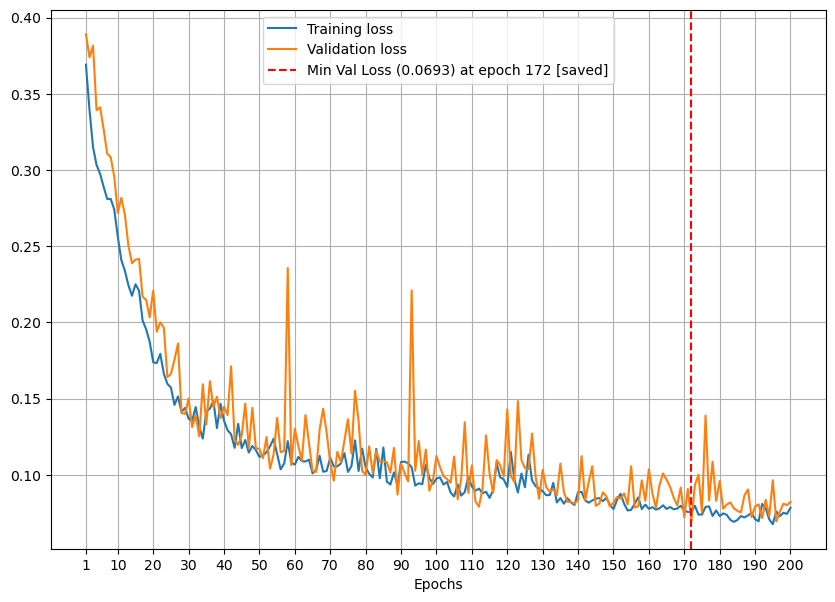

In [17]:
fig = plt.figure(figsize=(max(10, 0.05 * EPOCHS), 7))
plt.plot(np.arange(1, EPOCHS+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, EPOCHS+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, EPOCHS + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

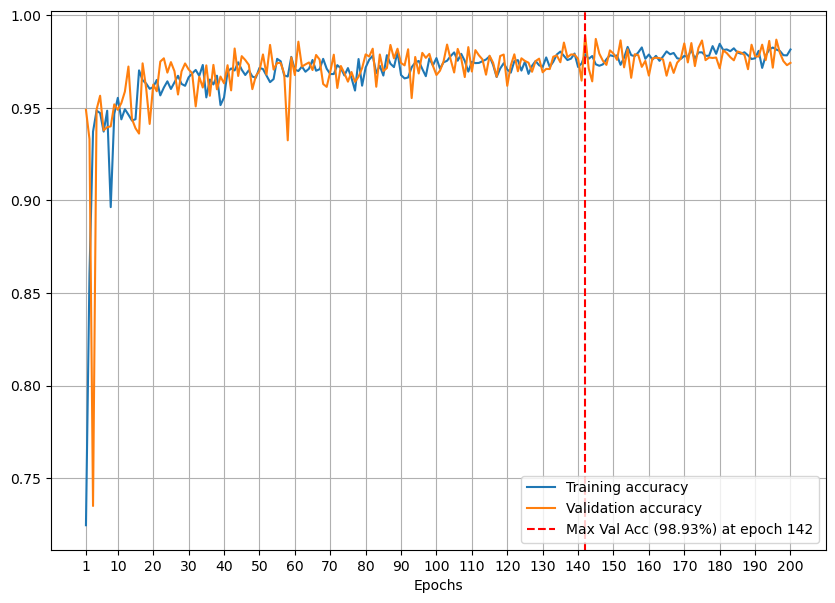

In [26]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * EPOCHS), 7))
plt.plot(np.arange(1,EPOCHS+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,EPOCHS+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, EPOCHS + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
#create model and load saved state 
'''model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
load_model_path = './trained_models/20250122_004444_UNet_0.04689'
model.load_state_dict(torch.load(load_model_path))'''
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

UNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, e

In [20]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/1st_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


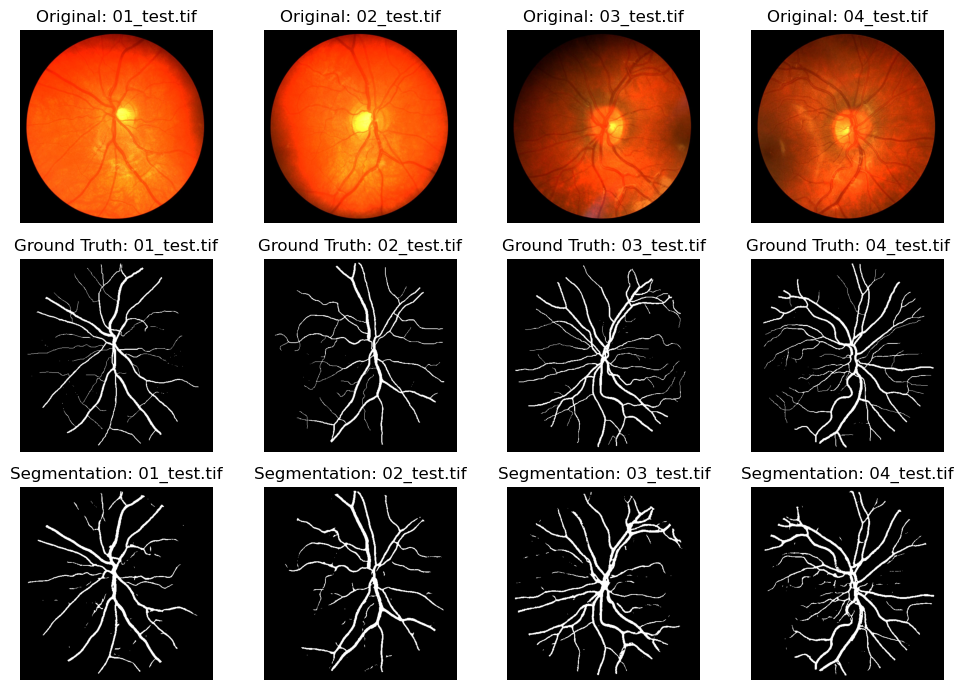

In [22]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

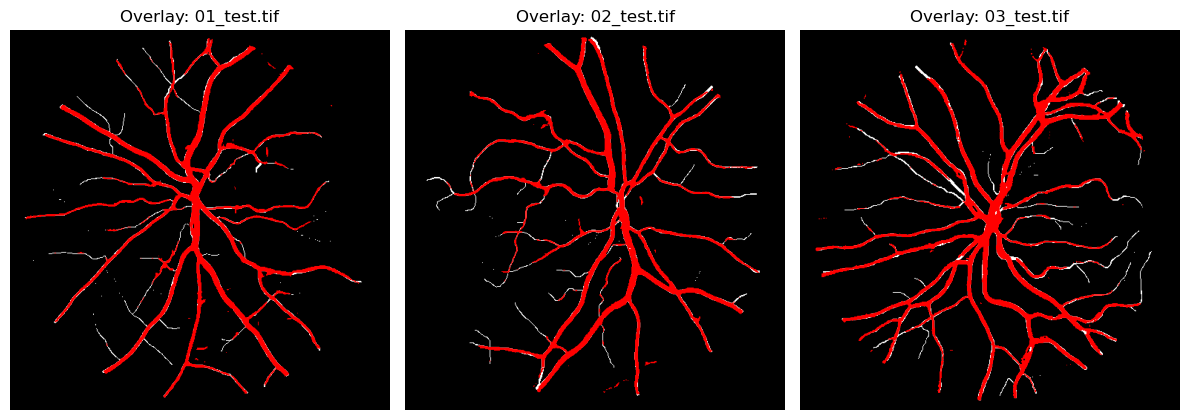

In [27]:
model.eval()   # done before, but just in case...

num_images = 3   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.7776

MCC: 0.7644

Test Accuracy: 0.9707

F1 Score: 0.7782




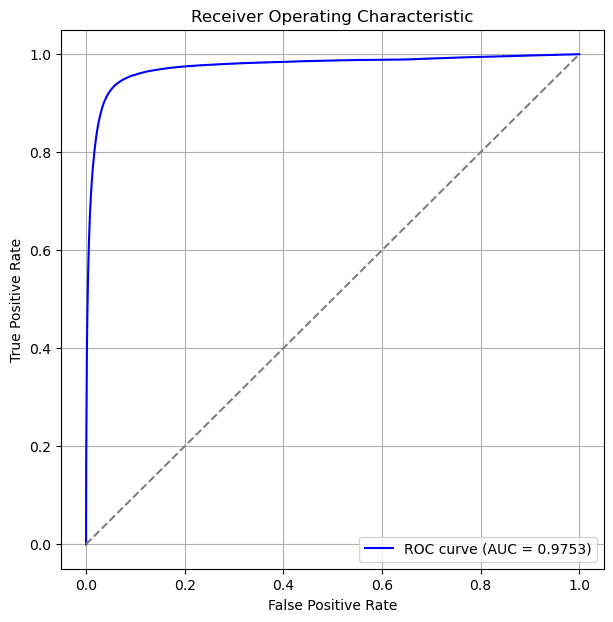

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = False    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [25]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'